In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import scipy as sp

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

## Pruebas con grafos dirigidos

In [2]:
g = nx.DiGraph()
g.add_nodes_from([1, 2, 3, 4, 5, 6])
g.add_edges_from([(1, 2), (1, 3), (1, 6),
                  (2, 3), (2, 4), (2, 5),
                  (3, 6)])
A = nx.to_scipy_sparse_matrix(g).T  # Matriz de Adyacencia
One = np.ones(6)
k_out = One.T@A  # Vector Grado Out
k_in = A@One  # Vector Grado In
D = np.diag(k_in)
L = D - A  # Laplaciano

/tmp/ipykernel_25633/476097011.py:6: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  A = nx.to_scipy_sparse_matrix(g).T  # Matriz de Adyacencia


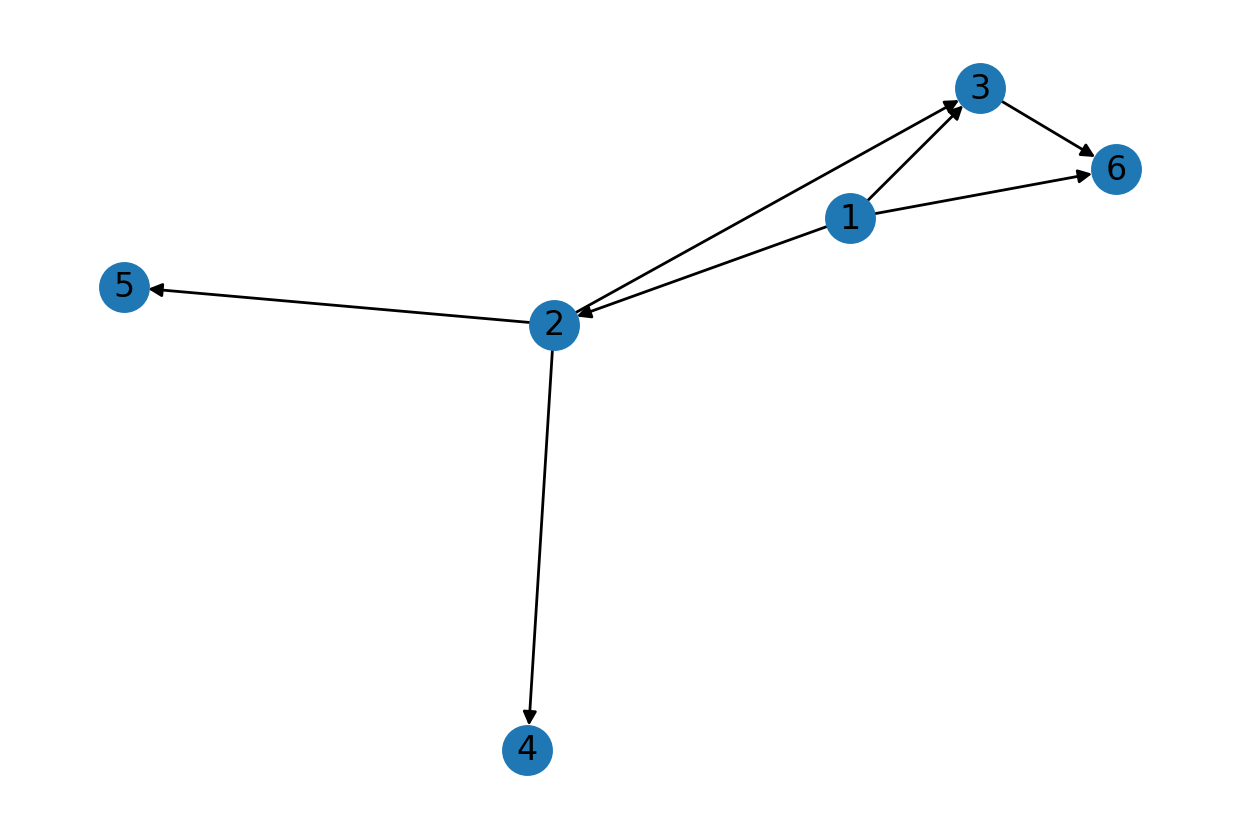

In [9]:
nx.draw(g, pos=nx.spring_layout(g, seed=15), with_labels=True,)

In [85]:
class SearchScope:

    def __init__(self, G) -> None:
        self.G = G
        self.scoped_nodes = {}

    def __call__(self, node: str, path: list = None) -> None:
        """
        Search scope of a node.

        Args:
            node (str): Node to search.
            path (list, optional): List of nodes reached before. Defaults to None.
        """
        
        neighs = list(nx.neighbors(self.G, node))
        scope = set()
        if path is None:
            path = []

        for n in neighs:
            if n not in path:
                try:
                    partial_scope = self.scoped_nodes[n]
                except KeyError:
                    if node not in path:
                        path.append(node)
                    self(n, path = path)
                    partial_scope = self.scoped_nodes[n]
                finally:
                    scope = scope | partial_scope | set([n])

        self.scoped_nodes[node] = scope
        print(len(self.scoped_nodes), end="\r")
    
        return None

{3: set(), 5: set(), 4: {5}, 2: {3, 4, 5}, 1: {2, 3, 4, 5}}

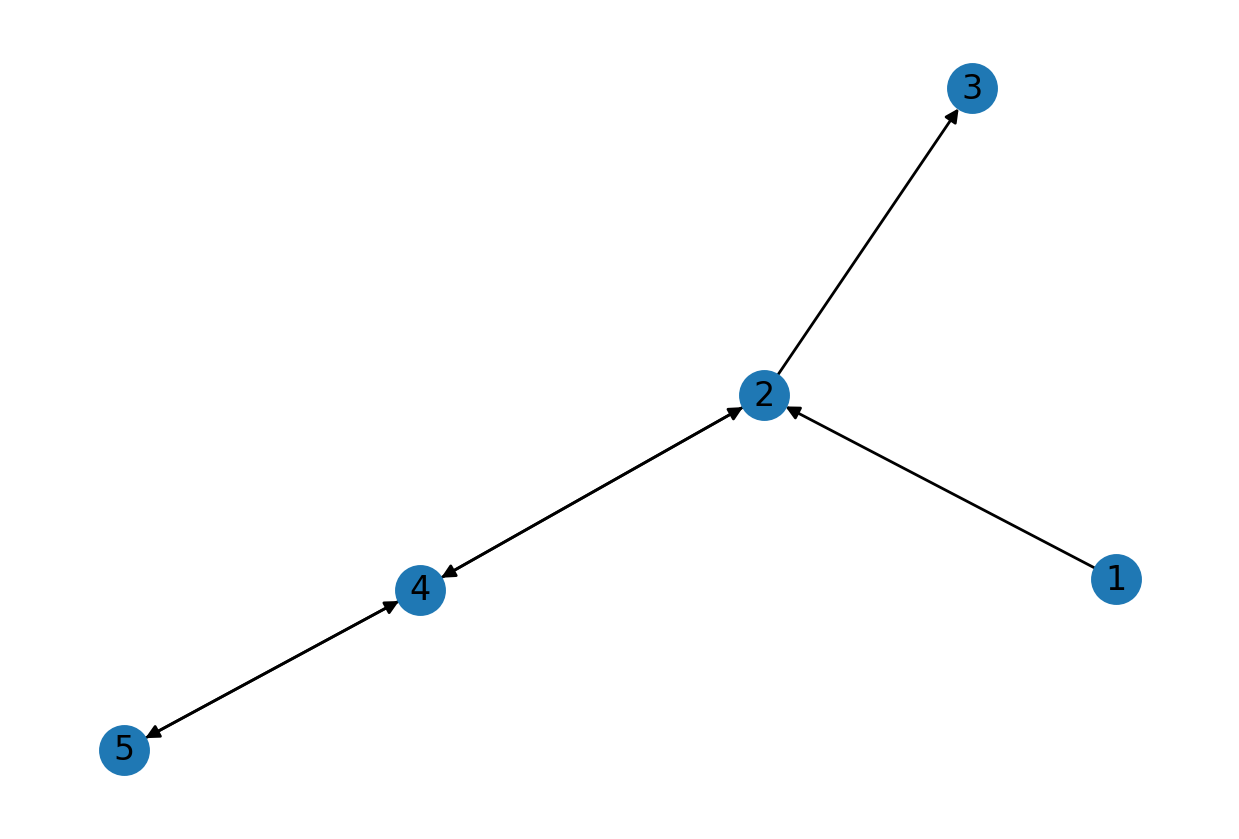

In [16]:
g = nx.DiGraph()
g.add_nodes_from([1, 2, 3, 4, 5])
g.add_edges_from([(1, 2), (2, 3), (2, 4), (4, 2), (4, 5), (5, 4)])

nx.draw(g, with_labels=True)
search = SearchScope(g)
search(1)
search.scoped_nodes

In [128]:
scoped_nodes = {}
def search_scope(g, node):
    neighs = list(nx.neighbors(g, node)) #Me guardo los primeros vecinos.
    scope = set() #Guardo el scope TOTAL del nodo.

    for n in neighs: # Me fijo por cada vecino si tengo el scope.
        try:
            partial_scope = scoped_nodes[n]
        except KeyError: #Si no lo tengo, que vaya a buscar el scope de ese nodo.
            search_scope(g, n)
            partial_scope = scoped_nodes[n]
        finally:
            scope = scope | partial_scope | set([n])#Me guardo el scope que tenía + el que encontré

    scoped_nodes[node] = scope #Me guardo el scope del nodo finalmente.

search_scope(g, 1)
scoped_nodes

{6: set(), 3: {6}, 4: set(), 5: set(), 2: {3, 4, 5, 6}, 1: {2, 3, 4, 5, 6}}

{}

# Intentos Vectorizados - descartados, requieren red acíclica (DAG)

In [ ]:
g = nx.DiGraph()
g.add_nodes_from([1, 2, 3, 4, 5, 6])
g.add_edges_from([(1, 2), (1, 3), (1, 6),
                  (2, 3), (2, 4), (2, 5),
                  (3, 6)])
A = nx.to_scipy_sparse_matrix(g).T  # Matriz de Adyacencia
One = np.ones(6)
k_out = One.T@A  # Vector Grado Out
k_in = A@One  # Vector Grado In
D = np.diag(k_in)
L = D - A  # Laplaciano

In [48]:
# A + A^2 + A^3
Ac = A.copy()
for j in range(2, 4):
    Ac += A**j
print(np.count_nonzero(np.asarray(Ac.todense()), axis=0, keepdims=False))
#print(np.sum(Ac.astype(bool), axis=0))

print(np.sum(sp.sparse.linalg.expm(A).astype(bool), axis = 0) - 1)

sum(np.diag((A**1).todense()))

[5 4 1 0 0 0]


# Intentos Agus

In [2]:
class ReachFinder:

    def __init__(self, G) -> None:
        self.G = G
        self.reached_from = {node: set() for node in G.nodes}
        self.calls = 0
    def __call__(self,) -> dict[set]:
        for n in self.G.nodes:
            self.find_from_node(n)
        print(f"\rDone. Function called {self.calls} times.")
        return self.reached_from
    
    def find_from_node(self, node: str, path: list = None) -> set:
        """
        Gets the reach of a node.

        Args:
            node (str): Node to search from.
            path (list, optional): List of nodes reached before. Defaults to None.
        """
        if len(self.reached_from[node]) == 0:  # Si ya estuve acá, no hago nada.
            self.reached_from[node].add(node)
            if path is None:
                path = []
            neighbors = list(nx.neighbors(self.G, node))
            for neigh in neighbors:
                if neigh not in path:
                    reach_from_neigh = self.find_from_node(neigh, path=path+[node])
                    self.reached_from[node].update(reach_from_neigh)
                else:
                    self.reached_from[node].update(self.reached_from[neigh])
                    self.reached_from[neigh] = self.reached_from[node]
            self.calls += 1
            print(f"\rFunction called {self.calls} times.", end="")
        return self.reached_from[node]

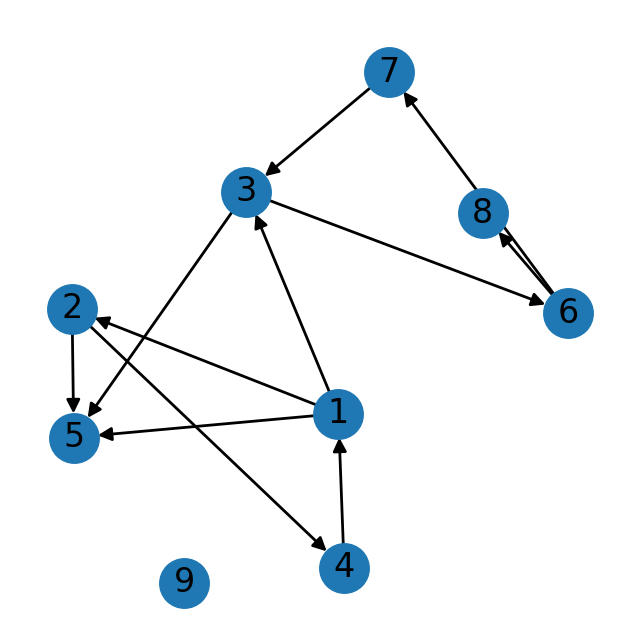

In [12]:
g = nx.DiGraph()
g.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8, 9])
g.add_edges_from([(1, 2), (1, 3), (1, 5),
                  (2, 4), (2, 5),
                  (3, 5), (3, 6),
                  (4, 1),
                  (6, 7), (6, 8),
                  (7, 3)
                  ])

plt.figure(figsize=(3, 3))
nx.draw(g, pos=nx.spring_layout(g, k=2, seed=15), with_labels=True)
plt.show()

finder = ReachFinder(g)

In [13]:
finder()

Done. Function called 9 times.


{1: {1, 2, 3, 4, 5, 6, 7, 8},
 2: {1, 2, 4, 5},
 3: {3, 5, 6, 7, 8},
 4: {1, 2, 3, 4, 5, 6, 7, 8},
 5: {5},
 6: {3, 5, 6, 7, 8},
 7: {3, 5, 6, 7, 8},
 8: {8},
 9: {9}}

In [3]:
G = nx.read_gexf("../PyPi Network V2.gexf")

In [4]:
finder = ReachFinder(G)

In [5]:
reach_dict= finder()

Done. Function called 169469 times.


In [16]:
reach_df = pd.DataFrame([(n, len(reached)) for n, reached in reach_dict.items()], columns=["Lib", "Reach"])


In [20]:
reach_df.sort_values("Reach", ascending=False).set_index("Lib").head(20)

,Reach
Lib,
numpy,115736
six,114398
django,113694
typing-extensions,113248
pyyaml,112804
pillow,112393
jinja2,112146
cython,112038
chardet,111953
